In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [14]:
figure_name = 'figures/fig_7_adaptation_background_noise_2_'

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
from scipy.signal import fftconvolve

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'
mpl.rcParams['font.family'] =  ['DejaVu Sans']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [34]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0
############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

In [31]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    gaba_inh += 0.16
    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*(g_r_out(r_gbc))  
    return  d_p_pc  / tau_p



# Input

In [39]:

# GABA parameter
# sbc_input_intensities = np.linspace(0.6,0.4,5)
# gbc_input_intensities = np.linspace(0.4,0.6,5)

sbc_input_intensities = np.linspace(0.0,1.0,11)
gbc_input_intensities = np.linspace(1.0,0.0,11)


background_noise_levels =  np.linspace(0.0,1.0,7)


# store values for different parameters
q_all = np.zeros((len(background_noise_levels), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(background_noise_levels), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(background_noise_levels), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))


############################################################
#                      Simulation                          #
############################################################

for l in range(len(background_noise_levels)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = gbc_input_intensities[k]
            
        # build ramps
        time_window = 400
        for i in range(time_window,len(t)):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = gbc_input_strength

        # create background noise
        s_gbc_all[time_window:,[0,1,3,4]] += background_noise_levels[l]
        
        # set noise in main band
        s_gbc_all[time_window:,gbc_center_frequencyBand] = np.maximum(s_gbc_all[time_window:,gbc_center_frequencyBand],background_noise_levels[l])
        
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
#         gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)        
        # DO NOT convolve because we have already a signal in the other frequency bands
#         s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')
#         s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask/gbc_gauss_mask.sum(),axis=1,mode='constant')

        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]

        # build ramps

        for i in range(time_window,len(t)):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = sbc_input_strength
        
        # create background noise
#         s_sbc_all[time_window:,[0,1,3,4]] += background_noise_levels[l]

        # set noise in main band
#         s_sbc_all[time_window:,sbc_center_frequencyBand] = np.maximum(s_sbc_all[time_window:,sbc_center_frequencyBand],background_noise_levels[l])
        
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
#         sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        # DO NOT convolve because we have already a signal in the other frequency bands
#         s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')
#         s_sbc_all = convolve1d(s_sbc_all,weights= sbc_gauss_mask/gbc_gauss_mask.sum(),axis=1,mode='constant')


        # Convolve with gauss curve to build a temporal ramp
        gauss_mask = gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1)
        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')
        gauss_mask = gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1)
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')



        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.6)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                gaba_inh_values[i,w] =   p_all[l,k,i,w]*0
                gaba_exc_values[i,w] =   p_all[l,k,i,w]*0.0




                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

                p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))





In [40]:
# c= plt.pcolormesh(s_gbc_all.T,cmap='viridis')
# plt.colorbar(c)
# plt.show()

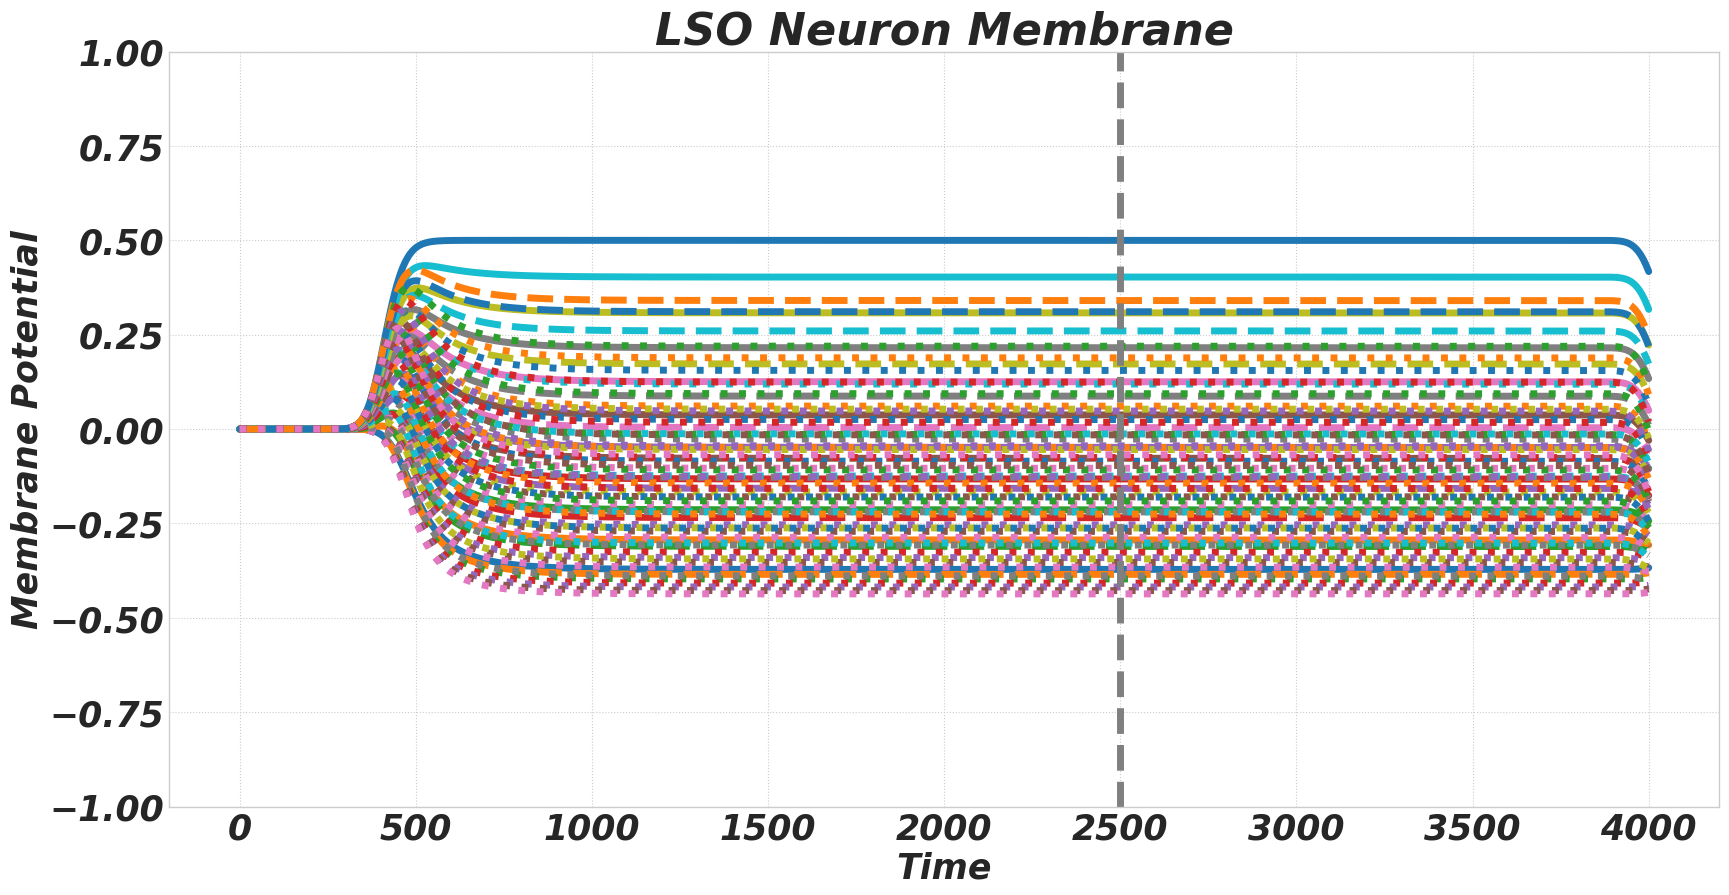

In [41]:
# Define the times when to probe
probing_times = [2500]
# show LSO neuron membrane
# show LSO neuron membrane
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]
fig = plt.figure()
ax2 = fig.add_subplot(111)
for j in range(0,len(background_noise_levels)):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        plt.plot(r[j,i,:],linestyle=line_style)
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])
plt.show()

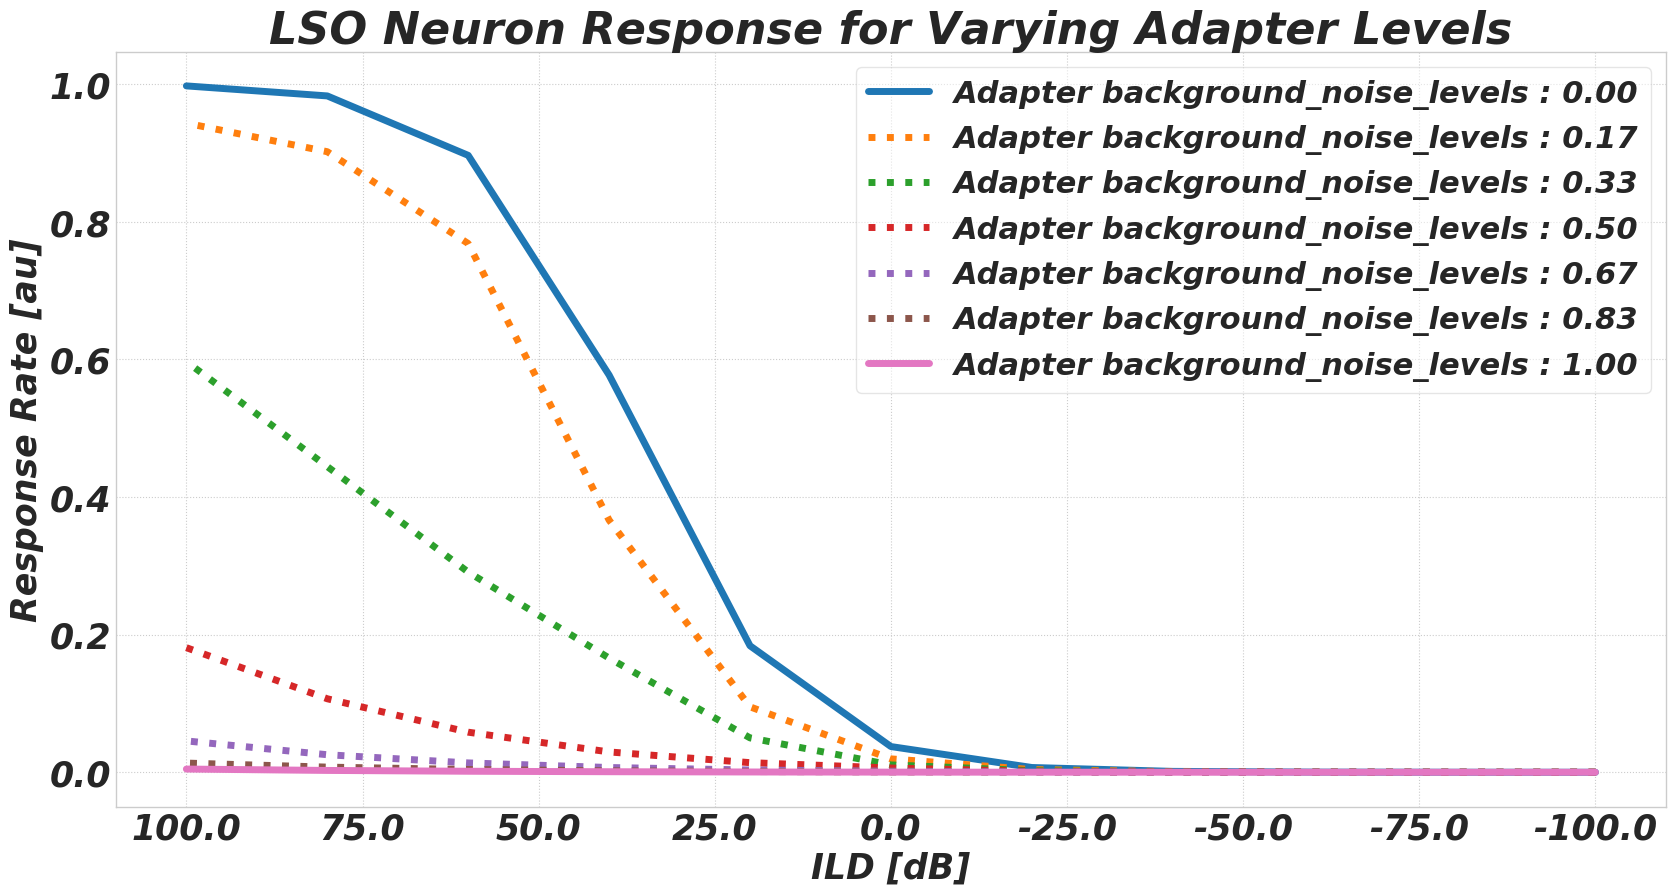

In [43]:
# Define the times when to probe
# probing_times = [3800]
# show LSO neuron membrane
# diff_input =  s_sbc_all-s_gbc_all
# diff_input = diff_input[:,sbc_center_frequencyBand]
diff = gbc_input_intensities-sbc_input_intensities

r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for j in range(len(background_noise_levels)):
    if j == 0 or j == len(background_noise_levels)-1:
        line_style = '-'
    else:
        line_style = ':'
        
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
        ax2.plot(-diff,tmp,linestyle=line_style,label='Adapter background_noise_levels : {0:.2f}'.format(background_noise_levels[j]))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

lgd = plt.legend()

# plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




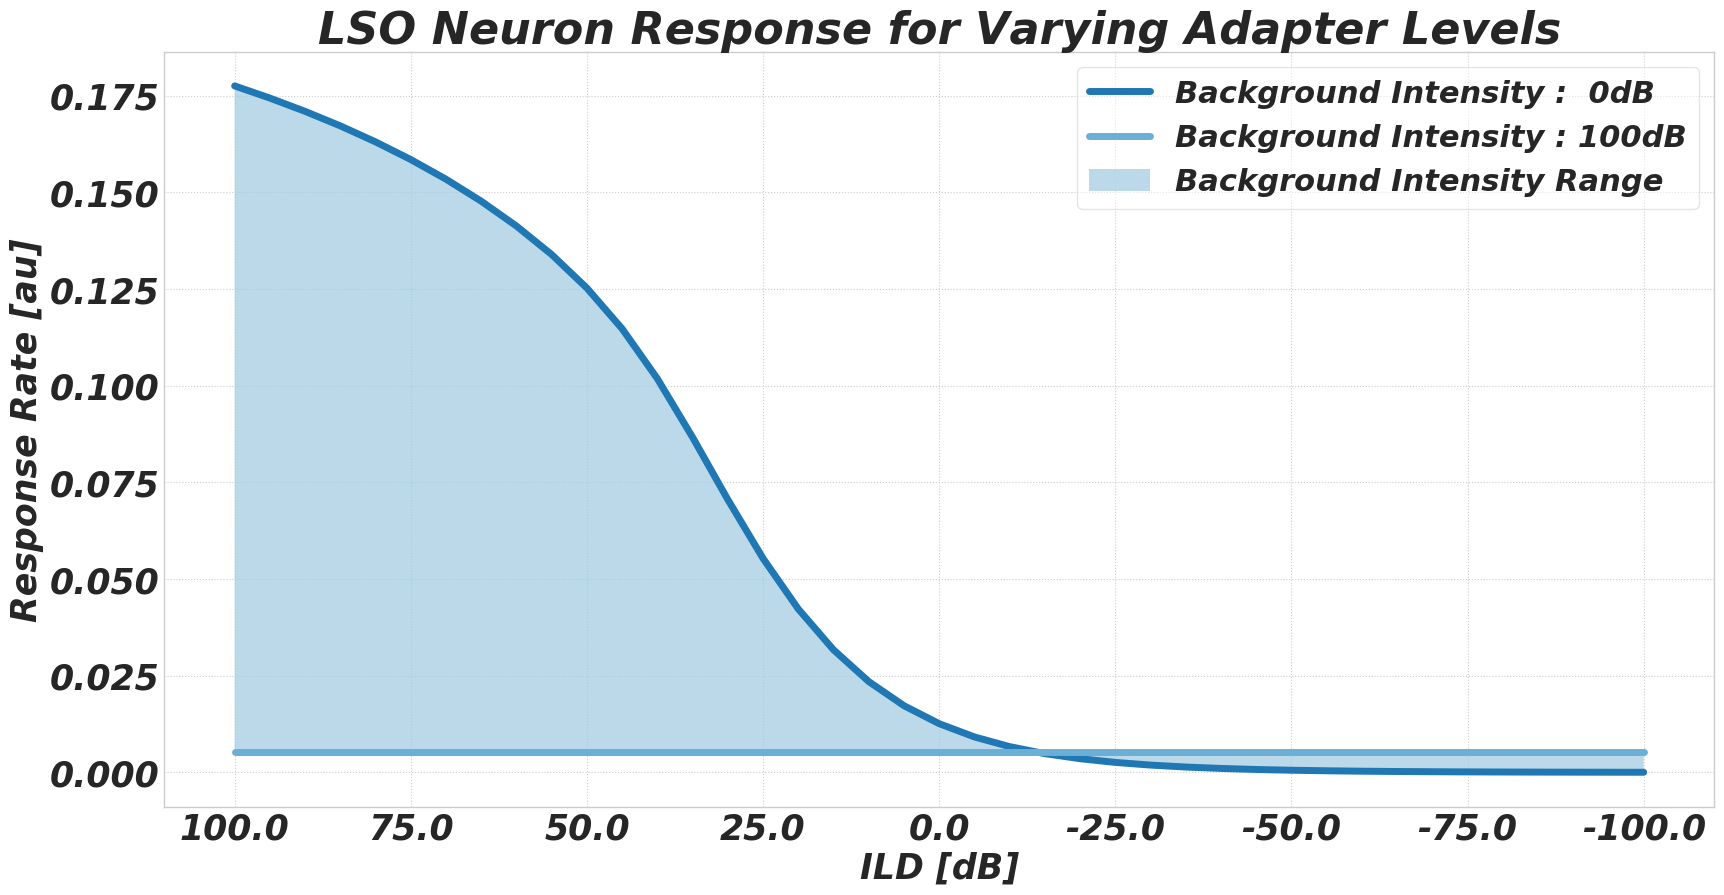

In [17]:
# Define the times when to probe
# probing_times = [1400]

fig = plt.figure()


diff = gbc_input_intensities-sbc_input_intensities

r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

## show LSO neuron response
ax2 = fig.add_subplot(111)
probing = probing_times[0]

tmp = g_r_out(r[0,:,probing])
ax2.plot(-diff,tmp,linestyle='-',label='Background Intensity : {0:2.0f}dB'.format(background_noise_levels[0]*100))

tmp2 = g_r_out(r[-1,:,probing])
ax2.plot(-diff,tmp2,linestyle='-',color='#6baed6',label='Background Intensity : {0:2.0f}dB'.format(background_noise_levels[-1]*100))

ax2.fill_between(-diff,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Background Intensity Range')

# # ax2.annotate("", xy=(0.90, 0.5), xytext=(0.45, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))
# # ax2.annotate("", xy=(1, 1), xytext=(1, 0.71),arrowprops=dict(arrowstyle="<->",linewidth=3))

# ax2.annotate("", xy=(0.57, 0.60), xytext=(0.91, 0.17),arrowprops=dict(arrowstyle="<-",linewidth=3))
# ax2.annotate("Suppression", xy=(0.35, 0.82), xytext=(0.80, 0.25))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

lgd = plt.legend()

plt.savefig(figure_name + 'response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




In [18]:
# fig = plt.figure()

# # probing_times = [1700]
# ## show LSO neuron response

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# ilds = np.zeros((r.shape[1],len(background_noise_levels)))
# for j in range(len(background_noise_levels)):
#     for i in range(0,len(probing_times)):
#         probing = probing_times[i]
#         tmp = g_r_out(r[j,:,probing])
# #         tmp /= np.max(tmp)
#         diff = gbc_input_intensities-sbc_input_intensities
#         ilds[:,j] = tmp
        
                
# ilds = ilds.T
# ax2.plot(diff,ilds.T)
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# # ax2.set_ylim([0,1.0])

# plt.title('Normalized Response')


# fig = plt.figure()

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# colors = plt.cm.Blues(np.linspace(0.8,0.2,ilds.shape[1]))
# ax2.set_prop_cycle('color', colors)
# ax2.plot(diff[:-1],-np.diff(ilds).T)
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.set_ylabel('Standard Separation D')
# # ax2.set_ylim([0,0.5])

# plt.title('Standard Separation D (Dahmen et. al )')


# plt.show()

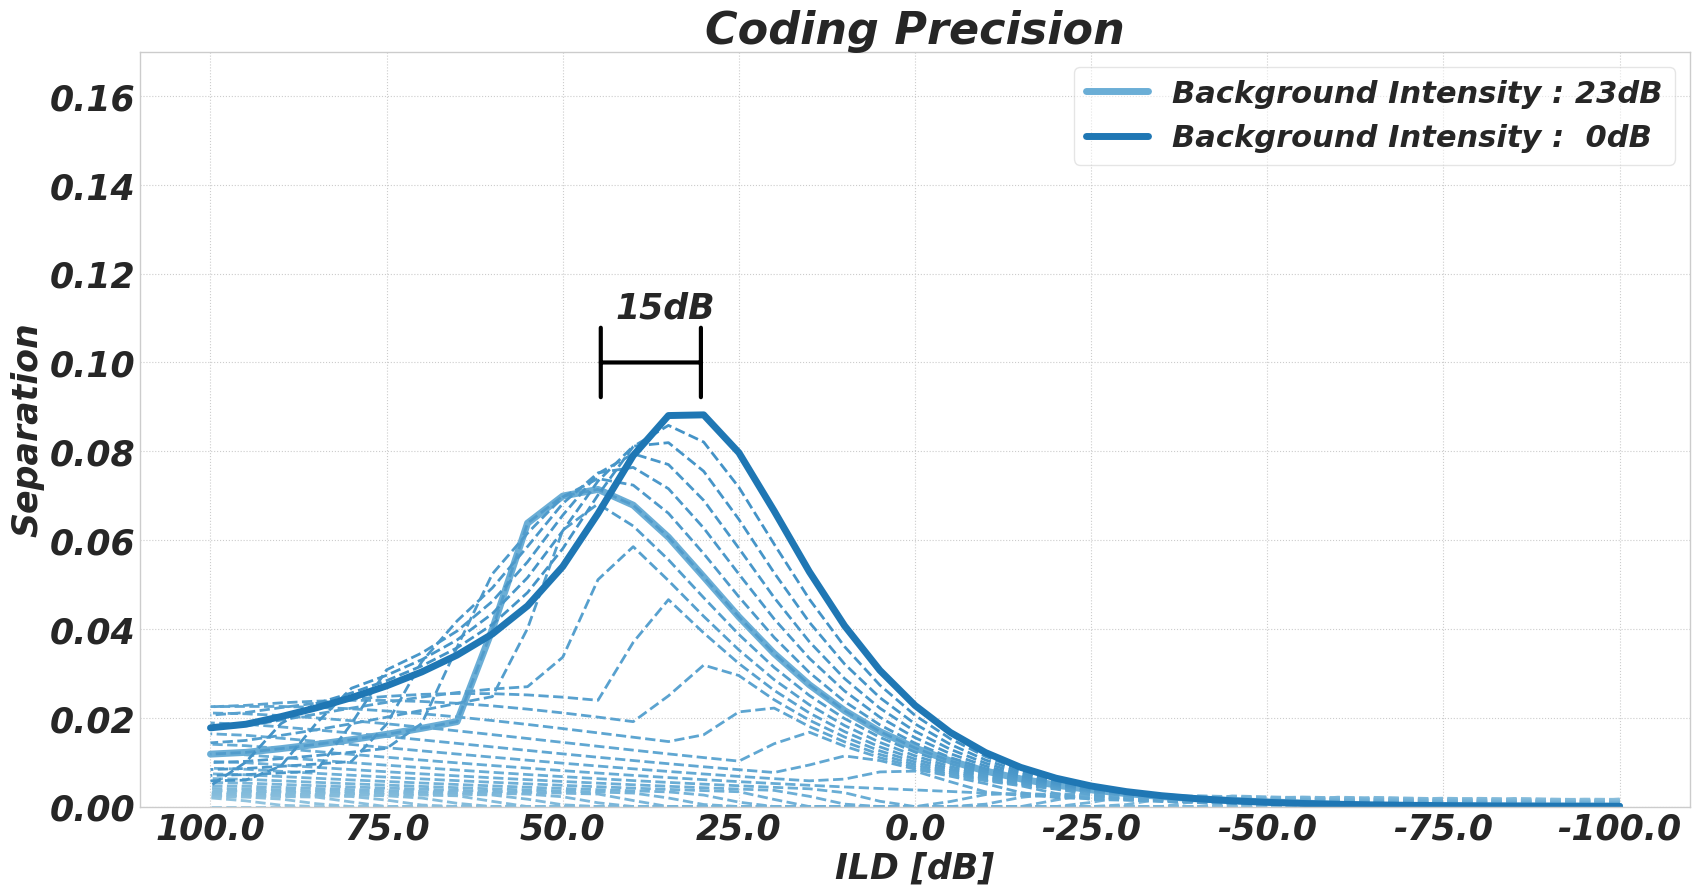

In [19]:
# fig = plt.figure()

# # probing_times = [1700]
# ## show LSO neuron response

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
ilds = np.zeros((len(background_noise_levels),r.shape[1]))
for j in range(len(background_noise_levels)):
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
#         tmp /= np.max(tmp)
#         diff = gbc_input_intensities-sbc_input_intensities
        ilds[j,:] = tmp
        
ilds = np.flip(ilds,0)          
from mpltools import color

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.4,0.7,ilds.shape[1]))
ax2.set_prop_cycle('color', colors)
# ilds = ilds[:,::-1]


norm_value = np.max(ilds.flatten())
# norm_value = 1
ilds /= norm_value

ilds = np.array(np.gradient(ilds,axis=1))



#######
# DIFF
#######
# ax2.plot(-diff[:-1],-np.diff(ilds).T,linewidth = int(drawing_size/9),linestyle='--')

# tmp = g_r_out(r[0,:,probing])

# # tmp = tmp / np.max(tmp)

# ax2.plot(-diff[:-1],-np.diff(tmp),linestyle='-',color='C0',label='Background Intensity : {0:2.0f}dB'.format(background_noise_levels[0]*100))

# tmp2 = g_r_out(r[-1,:,probing])

# # tmp2 = tmp2 / np.max(tmp2)
# ax2.plot(-diff[:-1],-np.diff(tmp2),linestyle='-',color='#6baed6',label='Background Intensity : {0:2.0f}dB'.format(background_noise_levels[-1]*100))

# # calculate x value for first peak
# x1 = diff[np.argmax(-np.diff(tmp))]
# x2 = diff[np.argmax(-np.diff(tmp2))]
# ax2.annotate("", xy=(-x2, 0.039), xytext=(-x1, 0.039),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}dB".format((x1-x2)*100), xy=((x2-x1)/2 -x2+0.05, 0.0396), xytext=((x2-x1)/2 -x2+0.05, 0.0396))


###########
# GRADIENT
###########

# tmp2 = g_r_out(r[-1,:,probing])/norm_value

# tmp2 = tmp2 / np.max(tmp2)
ax2.plot(-diff,ilds[24,:].T,linestyle='-',color='#6baed6',label='Background Intensity : {0:2.0f}dB'.format(background_noise_levels[len(background_noise_levels)-24]*100))

tmp = np.array( np.gradient(ilds/norm_value,axis=1))
ax2.plot(-diff,ilds.T,linewidth = int(drawing_size/9),linestyle='--')

tmp = g_r_out(r[0,:,probing])/norm_value

# tmp = tmp / np.max(tmp)

ax2.plot(-diff,ilds[-1,:].T,linestyle='-',color='C0',label='Background Intensity : {0:2.0f}dB'.format(background_noise_levels[0]*100))



# calculate x value for first peak
x1 = diff[np.argmax(ilds[-1,:])]
x2 = diff[np.argmax(ilds[24,:])]
ax2.annotate("", xy=(-x2, 0.1), xytext=(-x1, 0.1),arrowprops=dict(arrowstyle="|-|",linewidth=3))
ax2.annotate("{0:2.0f}dB".format((x1-x2)*100), xy=((x2-x1)/2 -x2+0.05, 0.11), xytext=((x2-x1)/2 -x2+0.05, 0.11))


# ax2.set_xticks(np.linspace(-1.0,1,9))
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
ax2.set_ylabel('Separation')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.17])
# ax2.set_xlim([1,-1])
ax2.legend()
plt.title('Coding Precision')

# plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')

plt.show()

